In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
from constants import regions

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### Create df_ratios dataframe

In [3]:
sys.argv[1] = 4
sys.argv[2] = 4

reduced_slide_list = [ (0.5, 0.5), (1, 0.5), (2, 0.5), (3, 0.5), (4, 0.5), (6, 0.5), (8, 0.5), (10, 1), (12, 1), (14, 1)]
super_reduced_slide_list = [ (0.5, 0.5), (1, 0.5), (2, 0.5), (4, 1), (6, 1), (8, 1), (10,1), (14, 1) ] 

In [ ]:
d_num = int( sys.argv[1] )
data_type = ['N2', 'N3','REM', 'Wake', 'N1'][3]


expt_num = int( sys.argv[2] )

#2. Load the data based on data type ___________________________________________________________
df = pd.read_hdf(os.path.join(os.path.abspath('..'),'Multiple_PSDs_Per_Participant/' + data_type + 'processed_multiple_psds_per_person.h5') , key = 'df')

y = df['y'].copy()
groups = df['groups'].copy()

df = df.drop(columns = ['groups', 'y'])

regional_dfs = {}

for region in regions:
    
    single_region_df = df[[col for col in df.columns if col.endswith('_' + region)]]
    frequency_vals  = np.arange(0.5,40.125, 0.125)
    single_region_df.columns = frequency_vals
    
    folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
    # paths = joblib.load(folder + data_type + '_paths.pkl')
    
    # groups = pd.Series(paths['s_p_id'])
    # s_class_list = pd.Series(paths['s_class_list'])
    # y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3})
    
    #3 Generate the frequency band search space ____________________________________________________
    width_slide_list = [(0.5,0.5)] 
    for window_width in range(1, 15 ):
        width_slide_list.append((window_width, 0.5) )
    
    #4 Calculate all of the features ________________________________________________________________
    feature_dfs = []
    
    for window_width_hz, window_slide_hz in super_reduced_slide_list:
        description = 'window width : ' + str(window_width_hz) + ' .  window stride : ' + str(window_slide_hz)
        
        #1.Set Window width in Hz and Window Slide in Hz
        # window_width_hz = 3
        window_len = (window_width_hz/0.125)+1
        assert window_len%1 == 0
        window_len = int(window_len)
        
        # window_slide_hz = 0.5 
        window_slide_len = window_slide_hz/0.125 
        assert window_slide_len%1 == 0
        window_slide_len = int(window_slide_len)
        
        
        #2.Calculate band values and store in dataframe calculated_df
        
        # Start of the window is the middle_freq value minus window_width_hz/2 
        # End of the window is the middle freq value plus window_width_hz/2
        window_len
        
        middle_freq = []
        final_cols = []
        
        i = 0
        while i < len(frequency_vals) - window_len:
            middle_freq.append( frequency_vals[i:i+window_len].mean() )
            band_vals = single_region_df.iloc[:,i:i+window_len].mean(axis = 1) #For every row calculate the mean for the appropriate elements
            
            final_cols.append(band_vals)
            
            # scaled_psd.append( psd_values[i:i+factor].mean() )
            i+= window_slide_len
        
        calculated_df = pd.DataFrame(final_cols).T
        calculated_df.columns = middle_freq
        
        calculated_df.columns = [ str(col) + '_width_' + str(window_width_hz) for col in calculated_df.columns]
        
        
        #3.Calculate Information Gain Based on Features
        #Change to binary HC vs PD / PD+RBD ---> Generate expt specific X,y,groups 
        X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(calculated_df,y,groups,expt_num)
    
        feature_dfs.append(X_expt)
            
    #5 Concatenate all feature_dfs into a single dataframe_________________________________________________________________
    X_expt_concatenated = pd.concat(feature_dfs, axis=1)

    #6 Calculate Frequency Ratio Columns
    calculated_cols = []
    col_names = []
    
    X_expt_ratios = X_expt_concatenated.copy() 
    
    for col_1 in X_expt_concatenated.columns:
        for col_2 in X_expt_concatenated.columns:
            if col_1 == col_2:
                pass
            else:
                new_col = col_1 + '/' + col_2  
                col_names.append(new_col)
                calculated_cols.append( X_expt_concatenated[col_1]/X_expt_concatenated[col_2] )
    
    df_ratios = pd.concat(calculated_cols, axis = 1)
    df_ratios.columns = col_names
    df_ratios_and_freq = pd.concat([df_ratios, X_expt_concatenated], axis = 1)
    regional_dfs[region] = df_ratios_and_freq.copy()
    print(region + 'done!')

#### Run Test Experiments

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

In [6]:
for region in regions: 
    DT = DecisionTreeClassifier(max_depth=2)
    X = regional_dfs[region] 
    DT.fit(X, y_expt)
    score = accuracy_score(y_expt,  DT.predict(X) )
    print(region + ' : ' + str(score) )

Prefrontal : 0.49427168576104746
Frontal : 0.4746317512274959
Left Frontal : 0.5450081833060556


KeyError: 'Right Frontal'

#### Plot trees and do scatter plot

0.35394456289978676


[Text(0.5, 0.75, '33.5_width_6/6.5_width_4 <= 0.323\nentropy = 1.979\nsamples = 469\nvalue = [100, 118, 101, 150]'),
 Text(0.25, 0.25, 'entropy = 1.942\nsamples = 384\nvalue = [99, 118, 53, 114]'),
 Text(0.75, 0.25, 'entropy = 1.066\nsamples = 85\nvalue = [1, 0, 48, 36]')]

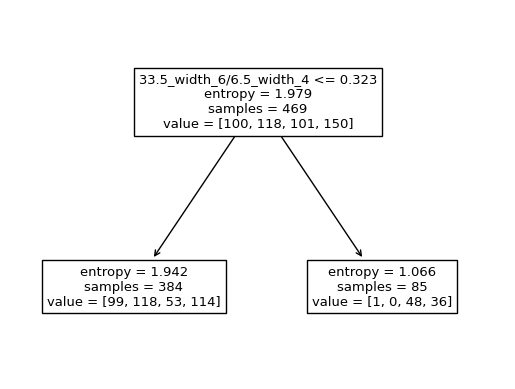

In [7]:
region = 'Prefrontal'
DT = DecisionTreeClassifier(criterion = 'entropy', max_depth=1)
X = regional_dfs[region] 

y_sub = y_expt[X[X.columns[60253]] < 9.5]
X_sub = X[X[X.columns[60253]] < 9.5]

# X = X.drop(columns = '4.5_width_8')
# X = X.drop(columns = '4.5_width_8/6.5_width_6')
# X_sub = X_sub.drop(columns = [ '15.5_width_4/18.5_width_8', '32.5_width_1/7.5_width_1', '7.5_width_1/32.5_width_1' , '18.5_width_8/15.5_width_4' ] )

DT.fit(X_sub, y_sub)
score = accuracy_score(y_sub,  DT.predict(X_sub) )
print(score)
plot_tree(DT, feature_names = list( X_sub.columns ) )

In [9]:
color_map = plt.cm.tab10
colors = color_map(np.linspace(0, 1, len(np.unique( groups_expt.values ))))
number_to_color = dict(zip(np.unique( groups_expt.values ), colors))

In [ ]:
class_label_dict = {'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3}

/tmp/ipykernel_121362/1758185496.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter( X.iloc[: , 60253][y_expt == 2] , X.loc[:, '32.5_width_1/7.5_width_1'][y_expt == 2 ]  , c = 'green' , marker = "x" ,edgecolors='black',  alpha = 0.4, label ='PD+RBD')


<Figure size 1500x800 with 0 Axes>

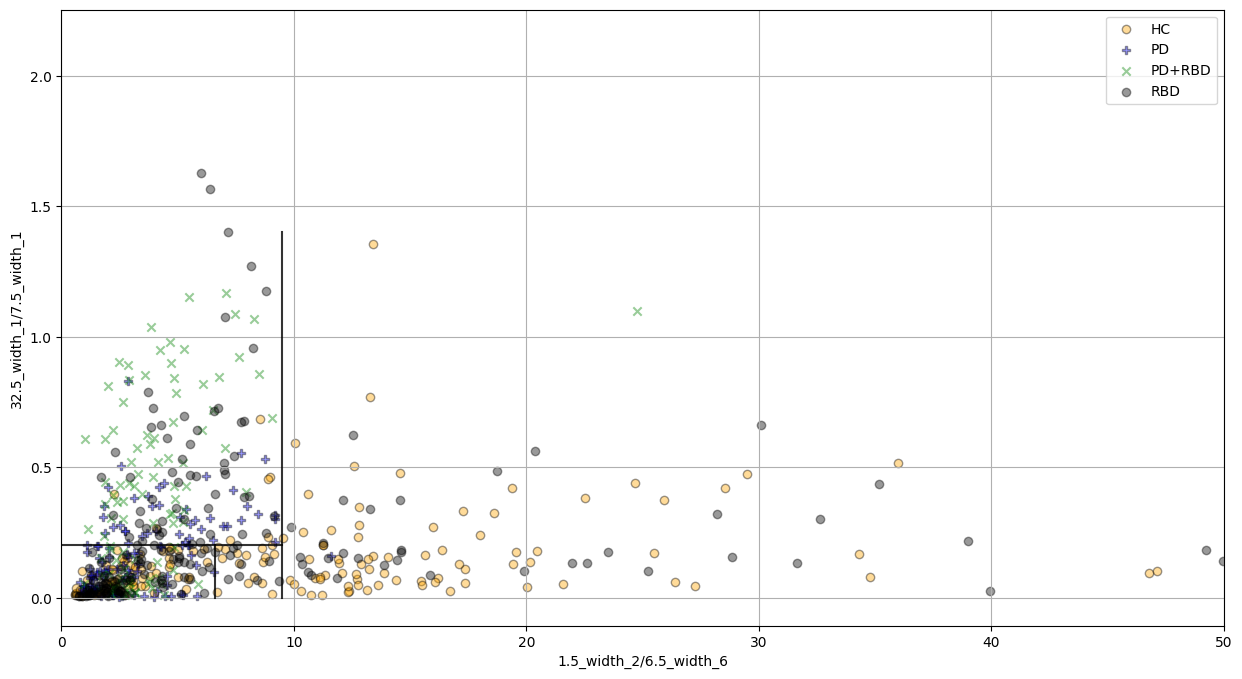

<Figure size 1500x800 with 0 Axes>

In [13]:
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (15,8)

X = regional_dfs['Prefrontal'] 
150456 , 60253

colors_mapped = groups_expt.map(number_to_color)


plt.scatter( X.iloc[: , 60253][y_expt == 0 ] , X.loc[:, '32.5_width_1/7.5_width_1'][y_expt == 0 ]  , c = 'orange' , marker = "o" , edgecolors='black', alpha = 0.4, label = 'HC')

plt.scatter( X.iloc[: , 60253][y_expt == 1] , X.loc[:, '32.5_width_1/7.5_width_1'][y_expt == 1 ]  , c = 'blue' , marker = "P" ,edgecolors='black',  alpha = 0.4, label ='PD')

plt.scatter( X.iloc[: , 60253][y_expt == 2] , X.loc[:, '32.5_width_1/7.5_width_1'][y_expt == 2 ]  , c = 'green' , marker = "x" ,edgecolors='black',  alpha = 0.4, label ='PD+RBD')

plt.scatter( X.iloc[: , 60253][y_expt == 3] , X.loc[:, '32.5_width_1/7.5_width_1'][y_expt == 3]  , c = 'black' , marker = "o" ,edgecolors='black',  alpha = 0.4, label ='RBD')


#Plot dividing lines that I'm interested in: 
plt.legend()

plt.plot( ([0, 9.5]) , ([0.2 , 0.2])  , c = 'black' , alpha = 0.8, label ='line') #horizontal line
plt.plot( ([9.5, 9.5]) , ([0 , 1.4])  , c = 'black' , alpha = 0.8, label ='line') #vertical line
plt.plot( ([6.6, 6.6]) , ([0 , 0.2])  , c = 'black' , alpha = 0.8, label ='line') #vertical line



# plt.plot( [0.663, 0.663] , [0.84,0.96] , c = 'b')
# plt.plot( [0.4, 1.55] , [0.879, 0.879] , c = 'b')
# plt.xlim(0.4, 1.55)
# plt.ylim(0.84, 0.96)
plt.ylabel('32.5_width_1/7.5_width_1')
plt.xlabel(X.columns[60253])
plt.grid() 
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0,50)


plt.figure()


# plt.grid() 
# plt.plot( ([0, 50]) , ([0.2 , 0.2])  , c = 'black' , alpha = 0.4, label ='PD')

# plt.scatter( X.iloc[: , 150456][y_expt == 1] , X.iloc[:, 60253][y_expt == 1 ]  ,  c = [float(val) for val in groups_expt[y_expt == 1 ]] , cmap = "viridis", alpha = 0.4, label ='PD')
# plt.ylim(0,175)

# plt.figure()

# plt.grid() 
# plt.plot( ([0.004, 0.016]) , ([9 , 9])  , c = 'g' , alpha = 0.4, label ='PD')

# plt.scatter( X.iloc[: , 150456][y_expt == 0] , X.iloc[:, 60253][y_expt == 0 ]  , c = 'purple' , alpha = 0.4, label ='HC')
# plt.ylim(0,175)

#### Prefrontal -
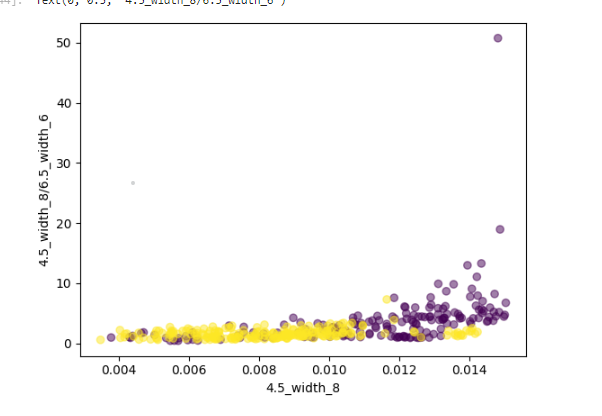

In [136]:
pd.set_option('display.max_columns', 30)

#### Find additional feature to sort people who are fully (mostly) in mixed region

In [ ]:
p_ids_mixed_region = 

#### Analyse number of people in each region

In [90]:
#1. Reduce dataframe to x and y only to make analysis easier
X_subset = X[['1.5_width_2/6.5_width_6', '32.5_width_1/7.5_width_1']].copy()
df = X_subset.copy()
df.columns = ['x','y']
# We have df , groups_expt and y_expt to generate the appropriate data

#2.Select appropriate rows for each region
region_1_rows_t_f = (df['x'] > 9.5)
region_2_rows_t_f = ( (df['x'] > 6.6) & (df['x'] < 9.5) & (df['y'] < 0.2))
region_3_rows_t_f = ((df['x'] < 9.5) & (df['y'] > 0.2))
region_4_rows_t_f = ((df['x'] < 6.6) & (df['y'] < 0.2))

rows_tf_list = [region_1_rows_t_f, region_2_rows_t_f, region_3_rows_t_f, region_4_rows_t_f]

#3. loop through region rows to create results_summary_dataframe
results_dataframe_dict = { 'Region' : [] , 'Class' : [], 'Group' : [], 'Num Samples' : [] } 
for i, rows_tf in enumerate(rows_tf_list):
    graph_region = 'Region_' + str(i + 1)
    for group_num in np.unique(groups_expt[rows_tf].values): 
        class_val = np.unique(y_expt[groups_expt == group_num].values)[0]
        num_samples = groups_expt[rows_tf].value_counts()[group_num]
        results_dataframe_dict['Region'].append(graph_region)
        results_dataframe_dict['Class'].append(class_val)
        results_dataframe_dict['Group'].append(group_num)
        results_dataframe_dict['Num Samples'].append(num_samples)

regional_results_dataframe = pd.DataFrame(results_dataframe_dict) # This dataframe is one long list, need to make it more readable

#Split into per region dataframes:
region_dfs = []
for region in ['Region_' + str(i) for i in range(1,5)]:
    region_dfs.append( regional_results_dataframe[regional_results_dataframe['Region'] == region].copy() )
    # display(regional_results_dataframe[regional_results_dataframe['Region'] == region])

#Concatenate into a single dataframe to maximise readability _______________________________________________________________________________
concat_df = pd.concat([df.reset_index() for df in region_dfs], axis = 1)
concat_df = concat_df.fillna(' ')
#Uncomment the below line for good readable regional statistics in a single dataframe
# display(concat_df) 

# Group the data points by class  then p_id (then region):
groups_results_dataframe_dict = { 'Group' : [] , 'Class' : [], 'Region_1' : [] , 'Region_2': [], 'Region_3' : [], 'Region_4' : [], 'Tot' : [] }

for group_num in np.unique(groups_expt.values): 
    groups_results_dataframe_dict['Group'].append(group_num)
    
    class_val = y_expt[groups_expt == group_num].values[0]

    groups_results_dataframe_dict['Class'].append(class_val)
    
    for i in [0,1,2,3]:
        col_name = 'Region_' + str(i + 1)
        try:
            region_samples = region_dfs[i][region_dfs[i]['Group'] == group_num]['Num Samples'].values[0]
            
        except:
            region_samples = 0 
            
        groups_results_dataframe_dict[col_name].append(region_samples)
    
    total_samps = (groups_expt == group_num).sum()
    
    groups_results_dataframe_dict['Tot'].append(total_samps)

groups_results_df = pd.DataFrame(groups_results_dataframe_dict)

#Display each class seperately
display(  groups_results_df[groups_results_df['Class'] == 0].sort_values(by = ['Region_1', 'Region_2'], ascending = False) )

groups_results_df[groups_results_df['Class'] == 1].sort_values(by = ['Region_3', 'Region_4'], ascending = False)

,Group,Class,Region_1,Region_2,Region_3,Region_4,Tot
11,1113,0,11,1,0,1,13
9,1111,0,11,0,1,0,12
7,1109,0,10,2,1,0,13
2,1103,0,10,0,0,0,10
12,1114,0,7,1,0,0,8
6,1108,0,7,0,2,0,9
13,1115,0,6,1,0,1,8
16,1118,0,6,1,1,1,9
10,1112,0,2,4,1,4,11
8,1110,0,2,2,0,8,12


,Group,Class,Region_1,Region_2,Region_3,Region_4,Tot
21,3304,1,0,0,26,1,27
23,3306,1,1,0,25,2,28
24,4401,1,0,0,14,7,21
22,3305,1,0,0,10,1,11
30,4408,1,0,0,10,1,11
28,4406,1,0,0,8,0,8
27,4405,1,1,0,5,3,9
26,4404,1,0,0,4,13,17
33,4411,1,0,0,4,10,14
18,3301,1,0,0,1,11,12
